<a href="https://colab.research.google.com/github/nehabhujbal222/Customer-Segmentation-RFM/blob/main/CustomerSegmentationUsingRFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

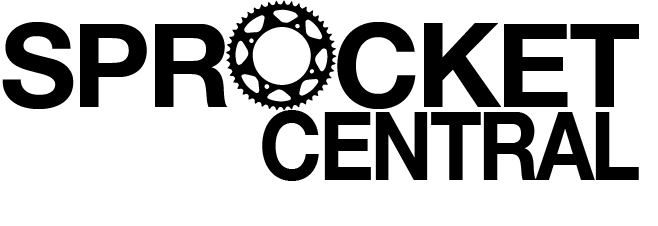



# **Customer Segmentation using RFM Approach** 
### **- Neha Bhujbal** 


---

**Dataset: Sprocket Central Pty Ltd Data Set**


This project is a part of my KPMG Data Analytics Consulting Virtual Internship experience. The aim is to analyse the Sprocket Central dataset which contains data about the bicycle company and its sales and identify which New Customers and Existing Customers the company should target to improve it's sales and maximize profits.

**Project Goal:**

*   Capture key business metrics (KPIs) measuring customer behaviour related to Transactions and Products.
*   Identify and segment Customers using Recency, Frequency, Monetary Value (RFM) approach


The segmentation based on different business metrics will thus help the  marketing and sales, account management and product teams to support better their customers and improve the product offering, availability and recommendations.

In [1]:
project_name = "Sprocket Central Data Analysis"

#**1. Importing Libraries**

In [2]:
!pip install squarify

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import squarify 


# **2. Exploratory Analysis**

## **2.1 Loading the Data**

In [4]:
raw_df = pd.read_excel('KPMG.xlsx')

In [5]:
raw_Transactions = pd.read_excel('KPMG.xlsx', sheet_name='Transactions')
raw_NewCust = pd.read_excel('KPMG.xlsx', sheet_name='NewCustomerList')
raw_CustDemog = pd.read_excel('KPMG.xlsx', sheet_name='CustomerDemographic')
raw_CustAddress = pd.read_excel('KPMG.xlsx', sheet_name='CustomerAddress')

## **2.2 Data Preprocessing and Feature engineering**

**2.2.1. NewCustomerList Data**

In [6]:
raw_NewCust.head(2)

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,0.46,0.575,0.71875,0.610938,1,1,1.71875
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11,0.62,0.620,0.77500,0.658750,1,1,1.71875


The *NewCustomer* csv file provides details for New Customers. It sets the benchmark for determining the columns which might help in analysis and find the KPI. 
This will enable the analyst to find which Customers among the NewCustomer List should be given a higher priority in terms of business.

In [7]:
raw_NewCust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

**Observations:**

1. New Customers haven't been assigned a customer id, so their identification is done on the basis of their first_name and last_name.
2. The data contains few missing values in the last_name, DOB, job_title, job_industry_category columns. 
3. The data contains 5 unnamed columns. It is difficult to understand what they represent. We will eliminate them to avoid ambiguity.

Let's create a copy of the data first so that we can continue to modify further without affecting the original data. (This step will be performed for all the imported csv files)

In [8]:
NewCustomer = raw_NewCust.copy()

In [9]:
selected_columns=['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value']

NewCustomer = NewCustomer[selected_columns]

In [10]:
# DOB of the eldest customer
NewCustomer['DOB'].min()

Timestamp('1938-06-08 00:00:00')

Let's add a new column to store the Ages of New Customers.

In [11]:
def calculate_age(dob): 
    today = date.today() 
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)) 
  
    return age 

In [12]:
NewCustomer['Age']= np.zeros(NewCustomer.shape[0])

NewCustomer['Age'] = pd.to_datetime(NewCustomer.DOB).apply(lambda x: calculate_age(x))

In [13]:
# Dividing Customer Age into different groups
NewCustomer['AgeGroup']= np.zeros(NewCustomer.shape[0])

pd.set_option('mode.chained_assignment', None)

for i in range(NewCustomer.shape[0]):
  if NewCustomer.Age[i] <= 10:
    NewCustomer.AgeGroup[i] = '1-10'
  elif NewCustomer.Age[i] <= 20:
    NewCustomer.AgeGroup[i] = '11-20'
  elif NewCustomer.Age[i] <= 30:
    NewCustomer.AgeGroup[i] = '21-30'
  elif NewCustomer.Age[i] <= 40:
    NewCustomer.AgeGroup[i] = '31-40'
  elif NewCustomer.Age[i] <= 50:
    NewCustomer.AgeGroup[i] = '41-50'
  elif NewCustomer.Age[i] <= 60:
    NewCustomer.AgeGroup[i] = '51-60'
  elif NewCustomer.Age[i] <= 70:
    NewCustomer.AgeGroup[i] = '61-70'
  elif NewCustomer.Age[i] <= 80:
    NewCustomer.AgeGroup[i] = '71-80'
  elif NewCustomer.Age[i] <= 90:
    NewCustomer.AgeGroup[i] = '81-90'
  else:
    NewCustomer.AgeGroup[i] = 'NaN'

In [14]:
NewCustomer.shape

(1000, 20)

*Setting up priority for New Customers* can be decided based on the set of parameters listed in the *selected_columns*. Therefore, *further analysis will be streamlined accordingly.*

**2.2.2. Transactions Data**

In [15]:
raw_Transactions.head(2)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0


The Transactions csv file provides insights about the bicycle transactions. It contains details about the product brand, class, size, cost, etc relating to the listed transactions.

In [16]:
Transactions = raw_Transactions.copy()

In [17]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

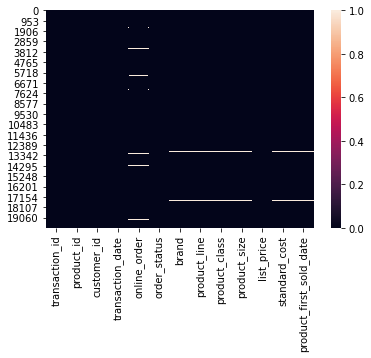

In [18]:
plt.show(sns.heatmap(Transactions.isnull()))

In [19]:
Transactions['order_status'].value_counts()

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

**Observations:**

1. The columns have datatype object, float or datetime.
2. The data has missing values for product line, product class, brand, product size, standard costs
and date of product first sold. It needs to be verified whether they are actual transactions or not. For now we will eliminate those rows as we cannot draw any valuable insight from them.
3. The column regarding whether the order was placed online or not isn't available for NewCustomerList data. Thus, the presence of null values in this column shouldn't have any influence on our results.
4. A transaction which is cancelled becomes invalid for the purpose of analysis. Thus, we will clean the data to contain only those transactions having order_status = 'Approved'
5. A certain amount of ambiguity lies around the product_id column with different product brands having same id. We need to figure out what product_id represents and corrections be made accordingly.

In [20]:
Transactions = Transactions.dropna()
#Transactions.replace(to_replace = {'online_order': {'FALSE': 0, 'TRUE': 1}}, inplace= True)

In [21]:
Transactions = Transactions.loc[Transactions['order_status'] == 'Approved']
Transactions['order_status'].unique()

array(['Approved'], dtype=object)

We will now add a new column named Profit to the Transactions data in order to keep a track of the sales profit.
> **Profit = list_price - standard_cost**





In [22]:
profit = Transactions['list_price'] - Transactions['standard_cost']
Transactions['Profit'] = profit

In [23]:
Transactions['product_first_sold_date'] = pd.to_datetime(Transactions['product_first_sold_date'])

In [24]:
Transactions.reset_index(drop = True, inplace = True)
Transactions.shape

(19273, 14)

 **2.2.3. CustomerDemographic Data**

In [25]:
raw_CustDemog

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,Rosalia,Halgarth,Female,8,1975-08-09,VP Product Management,Health,Mass Customer,N,-100,No,19.0
3996,3997,Blanch,Nisuis,Female,87,2001-07-13,Statistician II,Manufacturing,High Net Worth,N,â¦testâ§,Yes,1.0
3997,3998,Sarene,Woolley,U,60,NaT,Assistant Manager,IT,High Net Worth,N,NaN,No,NaN
3998,3999,Patrizius,NaN,Male,11,1973-10-24,NaN,Manufacturing,Affluent Customer,N,Â¡â¢Â£Â¢âÂ§Â¶â¢ÂªÂºââ,Yes,10.0


**2.2.4. CustomerAddress Data**

In [26]:
raw_CustAddress

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9
...,...,...,...,...,...,...
3994,3999,1482 Hauk Trail,3064,VIC,Australia,3
3995,4000,57042 Village Green Point,4511,QLD,Australia,6
3996,4001,87 Crescent Oaks Alley,2756,NSW,Australia,10
3997,4002,8194 Lien Street,4032,QLD,Australia,7


Upon comparison of the **CustomerDemographic** and **CustomerAddress** data on the basis of **customer_id**, it can be observed that:

CustomerDemographic has data missing for customer_id = 34

CustomerAddress has data missing for customer_id = 3, 10, 22 23

We will perform merge operation to get rid of the missing customer_id information.

**2.2.5 Merging and cleaning CustomerDemographic and CustomerAddress Data** 

In [27]:
Customer = pd.merge(raw_CustDemog, raw_CustAddress, on='customer_id')

In [28]:
Customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3996 entries, 0 to 3995
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3996 non-null   int64         
 1   first_name                           3996 non-null   object        
 2   last_name                            3871 non-null   object        
 3   gender                               3996 non-null   object        
 4   past_3_years_bike_related_purchases  3996 non-null   int64         
 5   DOB                                  3909 non-null   datetime64[ns]
 6   job_title                            3492 non-null   object        
 7   job_industry_category                3341 non-null   object        
 8   wealth_segment                       3996 non-null   object        
 9   deceased_indicator                   3996 non-null   object        
 10  default     

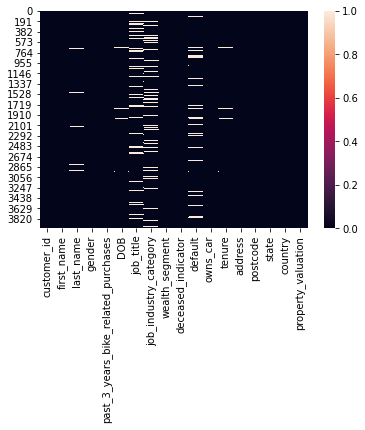

In [29]:
plt.show(sns.heatmap(Customer.isnull()))

In [30]:
Customer['gender'].value_counts()

Female    2035
Male      1870
U           88
Femal        1
F            1
M            1
Name: gender, dtype: int64

In [31]:
Customer['state'].value_counts()

NSW                2052
VIC                 939
QLD                 837
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [32]:
Customer.sort_values('DOB').head(2)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
29,34,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8
715,720,Darrel,Canet,Male,67,1931-10-23,Recruiting Manager,Retail,Affluent Customer,N,1;DROP TABLE users,No,6.0,78 Glacier Hill Drive,2026,NSW,Australia,10


**Observations:**
1. The **Customer data** contains a **lot of null values** as can be seen from the heatmap. 
2. Inconsistent values are present for **state** column such as 'New South Wales' and 'NSW' or 'Victoria' and 'VIC'
3. There exists an ambiguious Date of birth '1843-12-21' ie. the Customer is 177 years old which is practically impossible for a human. We will eliminate that row entry. 
4. Moreover, the column named **default** does not provide any value to the data so we will eliminate it as well.

**NOTE:** Unknown or blank values in the entire dataset can be an issue while looking up for customer information. To mitigate this issue it is recommended to record complete details of customers and transactions. For now we will eliminate incomplete records.

In [33]:
Customer = Customer.drop(columns='default')

In [34]:
Customer = Customer.dropna()

In [35]:
Customer.replace(to_replace={'gender': {'F': 'Female', 'Femal': 'Female', 'M': 'Male'}, 
                             'state': {'New South Wales': 'NSW', 'Victoria': 'VIC'}},
                 inplace=True)

In [36]:
deceased = Customer[Customer['deceased_indicator']=='Y'].index
Customer = Customer.drop(deceased)

index = Customer[Customer['DOB'] == '1843-12-21'].index
Customer = Customer.drop(index)

Customer.reset_index(drop = True, inplace = True)

Calculating the Age of Customers:

In [37]:
# Creating a new column to store the Age of Customers
Customer['Age']= np.zeros(Customer.shape[0])

# Assigning Age to each Customer using calculate_age function defined previously
Customer['Age'] = pd.to_datetime(Customer.DOB).apply(lambda x: calculate_age(x))

In [38]:
# Dividing Customer Age into different groups
Customer['AgeGroup']= np.zeros(Customer.shape[0])

pd.set_option('mode.chained_assignment', None)

for i in range(Customer.shape[0]):
  if Customer.Age[i] <= 10:
    Customer.AgeGroup[i] = '1-10'
  elif Customer.Age[i] <= 20:
    Customer.AgeGroup[i] = '11-20'
  elif Customer.Age[i] <= 30:
    Customer.AgeGroup[i] = '21-30'
  elif Customer.Age[i] <= 40:
    Customer.AgeGroup[i] = '31-40'
  elif Customer.Age[i] <= 50:
    Customer.AgeGroup[i] = '41-50'
  elif Customer.Age[i] <= 60:
    Customer.AgeGroup[i] = '51-60'
  elif Customer.Age[i] <= 70:
    Customer.AgeGroup[i] = '61-70'
  elif Customer.Age[i] <= 80:
    Customer.AgeGroup[i] = '71-80'
  elif Customer.Age[i] <= 90:
    Customer.AgeGroup[i] = '81-90'
  else:
    Customer.AgeGroup[i] = 'NaN'

In [39]:
Customer.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,Age
count,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000
mean,1964.236036,49.415495,10.698018,2987.002523,7.469550,43.035315
std,1148.971991,28.772232,5.673047,848.325742,2.840457,12.512323
min,1.000000,0.000000,1.000000,2000.000000,1.000000,19.000000
25%,969.500000,25.000000,6.000000,2197.000000,6.000000,34.000000
50%,1954.000000,49.000000,11.000000,2768.000000,8.000000,43.000000
75%,2951.500000,74.000000,16.000000,3749.500000,10.000000,52.000000
max,3997.000000,99.000000,22.000000,4883.000000,12.000000,89.000000


A large proportion of customers have **Age** between 33 years and 53 years. The mean **property _valuation** and **tenure** is 7.51 and 10.65 respectively.

In [40]:
Customer.sample(2)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Age,AgeGroup
1470,2077,Tobe,Lindroos,Female,67,1992-02-26,Cost Accountant,Financial Services,Mass Customer,N,Yes,7.0,27 Rockefeller Plaza,4556,QLD,Australia,8,29,21-30
1845,2604,Lewiss,Jaeggi,Male,91,1975-05-08,Account Executive,Retail,Mass Customer,N,Yes,7.0,6 Carioca Avenue,3185,VIC,Australia,9,45,41-50


## **2.3 Data Visualisation**

In [41]:
#formatting
%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#fff'

### **2.3.1 A Comparison between New Customer and Existing Customer Data**

The following exploratory analysis will help us gain a deeper insight into the general trends and type of customers who are in business with the company.

**Histogram plot for selected columns:**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ea3a8e8d0>,
      dtype=object)

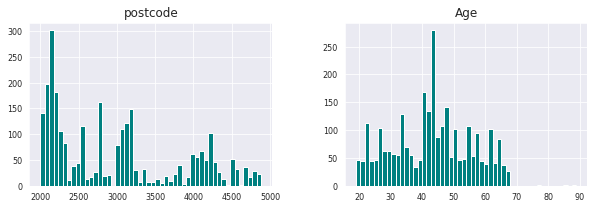

In [42]:
hist_columns = ['postcode', 'Age']

hist_Customer = Customer[hist_columns]
hist_Customer.hist(figsize=(10,3), bins=50, color='teal', xlabelsize=8, ylabelsize=8)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ea3bb1550>,
      dtype=object)

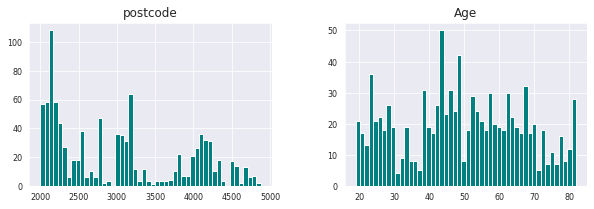

In [43]:
hist_NewCustomer = NewCustomer[hist_columns]

hist_NewCustomer.hist(figsize=(10, 3), bins=50, color='teal', xlabelsize=8, ylabelsize=8)

**Observations:**

*   A significant amount of customer base is present in particular Areas and Age as can be inferred from the histogram. 
*   The distribution w.r.t. postcode follows similar trends for Existing and New Customers
*   Whereas, certain variations w.r.t. distribution of Age is observed.

These parameters will be examined in order to understand the customer trends.

**Customers by Age Group and State:**


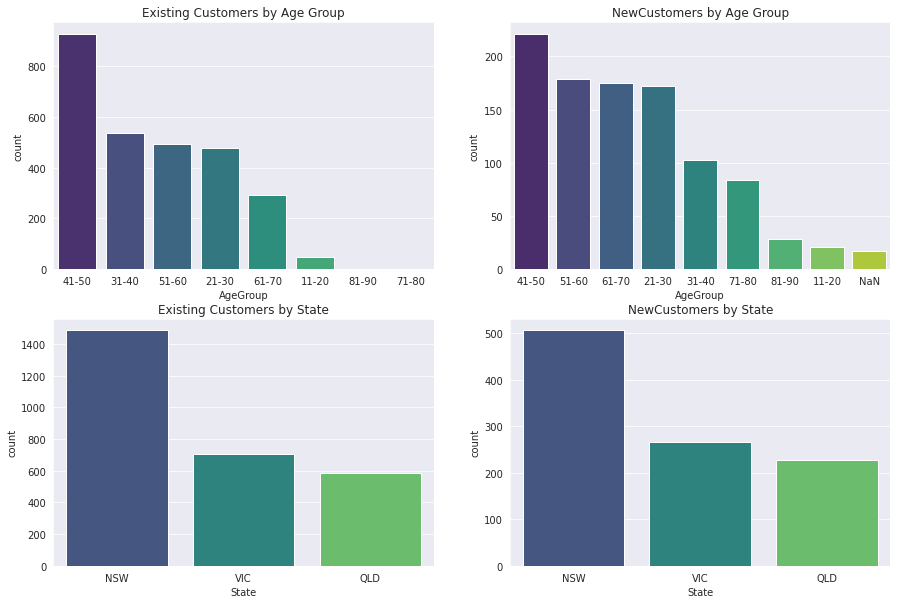

In [44]:
fig, ax =plt.subplots(2,2, figsize=(15,10))

sns.countplot(x='AgeGroup', data=Customer, order=Customer['AgeGroup'].value_counts().index, palette="viridis" ,ax=ax[0][0])
ax[0][0].set_title("Existing Customers by Age Group")
ax[0][0].set_xlabel("AgeGroup")

sns.countplot(x='AgeGroup', data=NewCustomer, order=NewCustomer['AgeGroup'].value_counts().index, palette="viridis" ,ax=ax[0][1])
ax[0][1].set_title("NewCustomers by Age Group")
ax[0][1].set_xlabel("AgeGroup")

sns.countplot(x='state',data=Customer, order= Customer['state'].value_counts().index, palette="viridis", ax=ax[1][0])
ax[1][0].set_title("Existing Customers by State")
ax[1][0].set_xlabel("State")

sns.countplot(x='state',data=NewCustomer, order= NewCustomer['state'].value_counts().index, palette="viridis", ax=ax[1][1])
ax[1][1].set_title("NewCustomers by State")
ax[1][1].set_xlabel("State")

plt.show()

**Gender w.r.t. Age Distribution:**

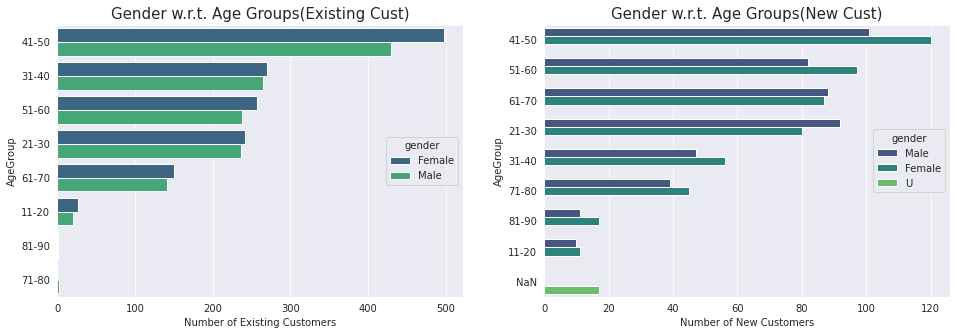

In [45]:
fig, ax =plt.subplots(1,2, figsize=(16,5))

sns.countplot(y='AgeGroup',hue='gender',data=Customer, order= Customer['AgeGroup'].value_counts().index, palette='viridis', ax = ax[0])
ax[0].set_ylabel("AgeGroup")
ax[0].set_xlabel("Number of Existing Customers")
ax[0].set_title("Gender w.r.t. Age Groups(Existing Cust)", fontsize=15)

sns.countplot(y='AgeGroup',hue='gender',data=NewCustomer, order= NewCustomer['AgeGroup'].value_counts().index, palette='viridis', ax= ax[1])
ax[1].set_ylabel("AgeGroup")
ax[1].set_xlabel("Number of New Customers")
ax[1].set_title("Gender w.r.t. Age Groups(New Cust)", fontsize=15)

plt.show();

**Distribution of Customers w.r.t. Wealth Segment:**

In [46]:
wealth_seg = Customer.wealth_segment.value_counts()
wealth_seg_new = NewCustomer.wealth_segment.value_counts()

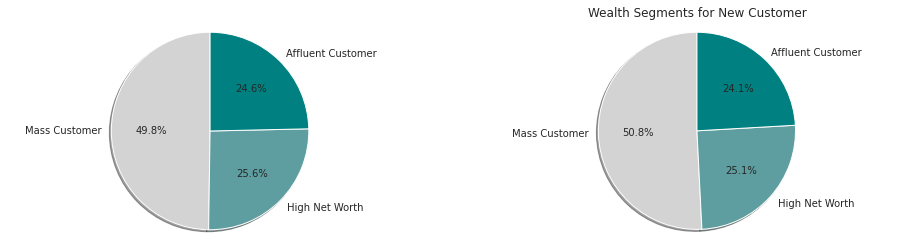

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

my_labels = 'Mass Customer','High Net Worth ','Affluent Customer'
my_colors = ['lightgrey', 'cadetblue','teal']
my_explode = (0,0,0)  #you can explode a slice if you want from the pie chart

ax1.pie(wealth_seg, explode = my_explode, startangle = 90, labels=my_labels, colors=my_colors, shadow= True, autopct='%1.1f%%')
plt.title('Wealth Segments for Existing Customer')
ax1.axis('equal')

ax2.pie(wealth_seg_new, explode = my_explode, startangle = 90, labels=my_labels, colors=my_colors, shadow= True, autopct='%1.1f%%')
plt.title('Wealth Segments for New Customer')
ax2.axis('equal')

plt.show()

**Distribution of Customers according to Job Industry Category:**

In [48]:
job_category = Customer.job_industry_category.value_counts()
job_category

Manufacturing         670
Financial Services    660
Health                528
Retail                296
Property              228
IT                    123
Entertainment         116
Argiculture            97
Telecommunications     57
Name: job_industry_category, dtype: int64

Plotting donut chart for distribution of New Customers w.r.t. wealth segment

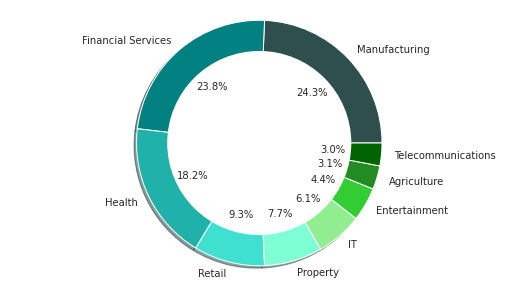

In [49]:
# The slices will be plotted counter-clockwise.
data = NewCustomer.job_industry_category.value_counts()
labels = 'Manufacturing', 'Financial Services', 'Health', 'Retail', 'Property', 'IT', 'Entertainment', 'Agriculture', 'Telecommunications'
colors = ['darkslategrey', 'teal', 'lightseagreen', 'turquoise', 'aquamarine',
             'lightgreen', 'limegreen', 'forestgreen',  'darkgreen' ]
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)  #you can explode a slice if you want from the pie chart

plt.pie(data, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
        
# Draw a circle at the center of the chart to make a donut chart
centre_circle = plt.Circle((0,0),0.75, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()


**Inferences:**

**AgeGroup**
*   Existing Customers within the **Age Group** of **41-50** are **most likely** to buy.
*   New Customers within the **Age Group** of **41-50** are **most likely** to buy followed by **51-60** and **61-70**.

**State**
*   **Maximum customer base** is in the state **NSW** followed by VIC and QLD for both existing and new customers.

**Gender**
*   The number of **female customers** is **slightly on a higher end** as compared to male customers for different Age Groups.

**Wealth Segment**
*  **Half of the customer base** belong to the **Mass Customer Segment** followed by High Net Worth and Affluent Customer for both existing and new customers.

**Job Category**
*  More than half of the Existing and New customer base belongs to either **Manufacturing, Financial Services or Health** Industry.

### **2.4 Transactions Data**

**2.4.1 Pairplot for selected columns:**

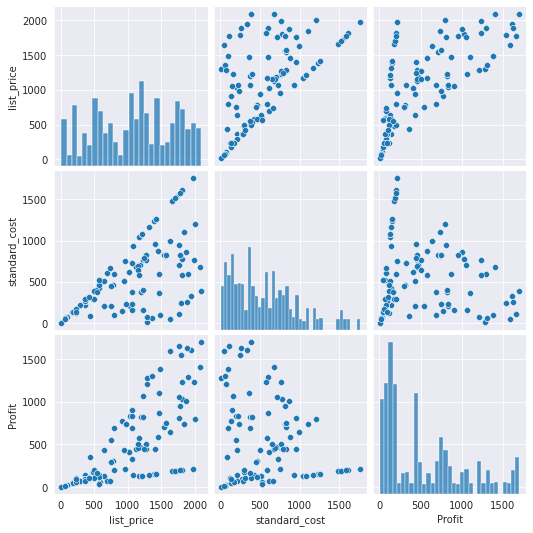

In [50]:
sns.pairplot(Transactions, vars= ['list_price', 'standard_cost', 'Profit'])

It can be quite easily inferenced from the above plot that Profit and list_price hold a direct relationship. It is quite obvious as profit increases if you set the selling price(list_price) higher compared to the cost price(standard_cost)

**2.4.2 Top selling brands:**

In [51]:
Transactions['brand'].value_counts()

Solex             4128
Giant Bicycles    3217
WeareA2B          3215
OHM Cycles        2967
Trek Bicycles     2906
Norco Bicycles    2840
Name: brand, dtype: int64

**2.4.3 Demand of bikes w.r.t. product line:**

In [52]:
count_productline = Transactions['product_line'].value_counts()
count_productline

Standard    13795
Road         3859
Touring      1204
Mountain      415
Name: product_line, dtype: int64

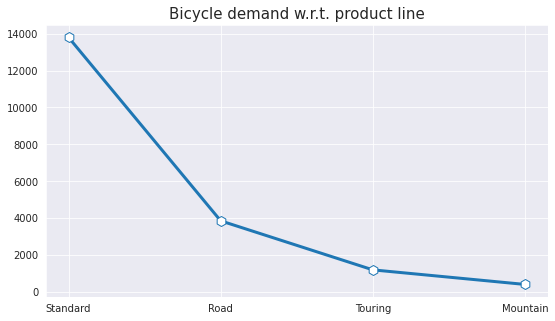

In [53]:
plt.plot(count_productline, marker='h', markersize=10, linewidth=3, markerfacecolor='white')
plt.title('Bicycle demand w.r.t. product line', fontsize= 15)
plt.show()

**Inferences:**



*   Profit and list_price hold a direct relationship. It is quite obvious as, profit increases if you set the selling price(list_price) higher compared to the cost price(standard_cost).
*   The **Top 3 bicycle brands** are **Solex, Giant Bicycles** and **WeareA2B**. 
*  In terms of Product line, **Standard bikes** are the **highest in demand** followed by Road, Touring and Mountain bikes.


# **3. Key Performance Indicators (KPIs)**


---



A Key Performance Indicator is a measurable value that demonstrates how effectively a company is achieving its key business objectives. Organizations use KPIs to evaluate their success at reaching specific targets. 

In this section, the following categories of KPIs will be examined in detail.

**Transactions KPI:**
*   Monthly Revenue
*   Growth Rate
*   Profits incurred
*   Monthly transactions count

**Products KPI:**
*   Monthly profit per brand



In [54]:
Transactions.head(2)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,1970-01-01 00:00:00.000041245,17.87
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,1970-01-01 00:00:00.000041701,1702.55


The transaction details are available from 01/01/2017 to 30/12/2017

In [55]:
Transactions['Year'] = pd.DatetimeIndex(Transactions['transaction_date']).year
Transactions['Month'] = pd.DatetimeIndex(Transactions['transaction_date']).month
Transactions['Month-Year'] = pd.to_datetime(Transactions['transaction_date']).dt.to_period('M')

###**3.1 Transaction KPIs:**

**Dataframe for monthly Transaction KPIs:**

In [56]:
# 1. Monthly KPIs DataFrame by aggregating Revenue
t_kpi = pd.DataFrame(Transactions.groupby(Transactions['Month-Year'])['list_price'].sum())
t_kpi.rename(columns = {'list_price': 'MonthlyRevenue'}, inplace=True)

# 2. Monthly Growth rate based on previous months Revenue
t_kpi['MonthlyGrowth'] = t_kpi['MonthlyRevenue'].pct_change()

# 3. Profits incurred per Month
t_kpi['MonthlyProfit'] = pd.DataFrame(Transactions.groupby(Transactions['Month-Year'])['Profit'].sum()).round(decimals = 2)
#t_kpi['MonthlyProfit'] = t_kpi['MonthlyProfit'].round(decimals = 2)

# 4. Monthly Transactions count
t_kpi['MonthlyTransactionsCount'] = pd.DataFrame(Transactions.groupby(Transactions['Month-Year'])['transaction_id'].count())

#m_kpi.reset_index(level=0, inplace=True)
t_kpi

,MonthlyRevenue,MonthlyGrowth,MonthlyProfit,MonthlyTransactionsCount
Month-Year,,,,
2017-01,1796720.93,NaN,904893.87,1621
2017-02,1739750.40,-0.031708,851637.74,1573
2017-03,1739423.16,-0.000188,860463.96,1585
2017-04,1770014.90,0.017587,879340.04,1596
2017-05,1847713.53,0.043897,895150.25,1624
2017-06,1690718.45,-0.084967,831655.67,1518
2017-07,1824201.43,0.078950,913216.65,1656
2017-08,1866475.46,0.023174,944061.90,1687
2017-09,1682750.63,-0.098434,835514.83,1520


**Plotting the KPIs:**

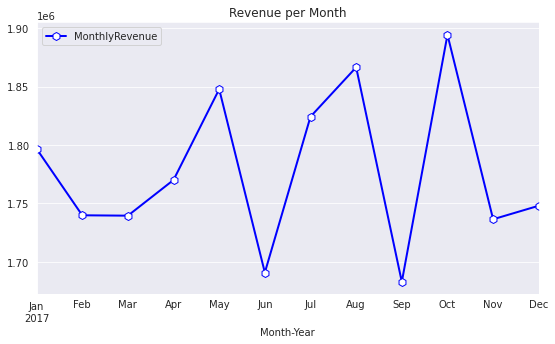

In [57]:
# Line Graph to capture the monthly revenue
t_kpi.plot.line(y='MonthlyRevenue', title='Revenue per Month',color = 'b', 
                marker='h', markersize=8, linewidth=2, markerfacecolor='white');

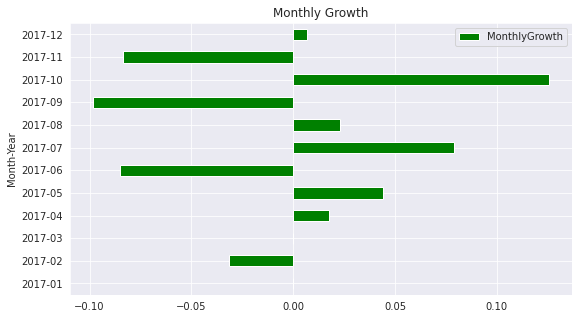

In [58]:
t_kpi.plot.barh(y='MonthlyGrowth',title='Monthly Growth', color= 'g');

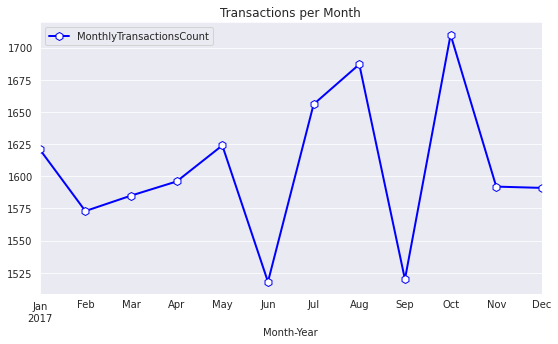

In [59]:
# Line Graph to capture the monthly revenue
t_kpi.plot.line(y='MonthlyTransactionsCount', title='Transactions per Month',color = 'b', 
                marker='h', markersize=8, linewidth=2, markerfacecolor='white');

### **3.2 Product KPIs:**

In [60]:
Transactions.head(2)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit,Year,Month,Month-Year
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,1970-01-01 00:00:00.000041245,17.87,2017,2,2017-02
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,1970-01-01 00:00:00.000041701,1702.55,2017,5,2017-05


**Dataframe for monthly Product KPI**

In [61]:
p_kpi = pd.DataFrame(Transactions.groupby([Transactions.Year, Transactions.Month, Transactions.brand])['Profit'].sum()).round(decimals= 2)
p_kpi.index.set_names(['Year', 'Month', 'brand'], inplace = True)
p_kpi

Profit
Year Month brand                    
2017 1     Giant Bicycles  125049.35
           Norco Bicycles   71659.77
           OHM Cycles      130794.65
           Solex           206908.79
           Trek Bicycles   143548.19
...                              ...
     12    Norco Bicycles   69543.43
           OHM Cycles      113275.88
           Solex           164199.91
           Trek Bicycles   136566.79
           WeareA2B        242731.88

[72 rows x 1 columns]

**Plotting the KPI**

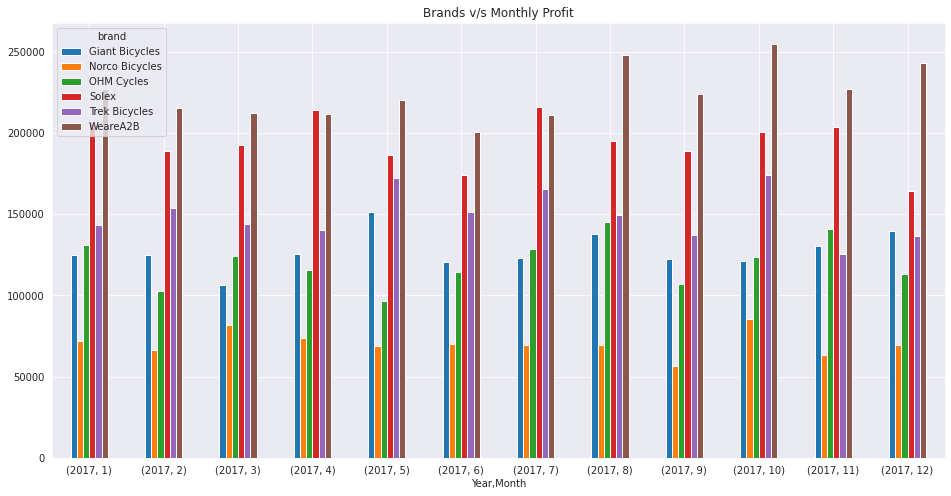

In [62]:
p_kpi.unstack().plot.bar(y='Profit', title='Brands v/s Monthly Profit', rot=0, figsize= (16,8));

# **4. Customer Segmentation using RFM**

RFM stands for **“Recency, Frequency, Monetary Value”**. It is a way to figure out who your most valuable customers are. In this section, a **points system** is developed where **a number from 1 to 5** is assigned for each category, 5 implying highest value.

In order to calculate RFM score, the following Customer data is required:
1. Their most recent purchase date
2. Number of purchases within a set time period (i.e. one year)
3. Total sales from that customer

## **4.1 Preparing Data**

In [63]:
rfm_df = Transactions.copy()

# Merging of Transactions and Customer data
rfm_df = rfm_df.merge(Customer, on='customer_id', how='left')

In [64]:
rfm_df = rfm_df.dropna()

In [65]:
columns = ['customer_id', 'transaction_id', 'transaction_date', 'list_price', 'standard_cost', 'Profit']
rfm_df = rfm_df[columns]

rfm_df.head(2)

,customer_id,transaction_id,transaction_date,list_price,standard_cost,Profit
0,2950,1,2017-02-25,71.49,53.62,17.87
1,3120,2,2017-05-21,2091.47,388.92,1702.55


In [66]:
rfm_df.shape

(13488, 6)

## **4.2 Recency (R)**

A Customer who has purchased recently from a company is more likely to continue to keep the bussiness and brand in mind for subsequent purchases as compared to customers who haven't been purchased for a while.

**Scoring Methodology:** Assign a score from 1-5 to the customer on the basis of their latest purchase where 5 denotes the most recent purchase.

In [67]:
# To calculate recency we will need customer_id and date of transaction
R_df = rfm_df[['customer_id', 'transaction_date']].copy()
R_df = R_df.drop_duplicates().sort_values('transaction_date', ascending= False)

R_df.reset_index(drop = True, inplace = True)
R_df.shape

(13407, 2)

In [68]:
R_df.head(2)

,customer_id,transaction_date
0,195,2017-12-30
1,151,2017-12-30


In [69]:
R_df = R_df.groupby('customer_id',as_index=False).transaction_date.max()

In [70]:
R_df['R_days'] = (R_df['transaction_date'].max() - R_df['transaction_date']).dt.days

In [71]:
R_df.head()

,customer_id,transaction_date,R_days
0,1,2017-12-23,7
1,2,2017-08-24,128
2,9,2017-10-13,78
3,12,2017-10-24,67
4,13,2017-12-03,27


The latest date for transaction is **30/12/2017**

In [72]:
r_labels = range(1, 6)
r_groups = pd.qcut(R_df['transaction_date'], q=5, labels=r_labels)

R_df = R_df.assign(R = r_groups.values)
R_df.head()

,customer_id,transaction_date,R_days,R
0,1,2017-12-23,7,5
1,2,2017-08-24,128,1
2,9,2017-10-13,78,2
3,12,2017-10-24,67,2
4,13,2017-12-03,27,4


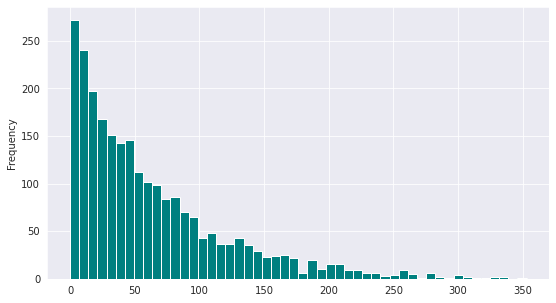

In [73]:
R_df.R_days.plot.hist(bins=50, color='teal')

As customer_id is repeated several times in the result, we take the maximum value of R as the recency score for each customer. We will now group the result by customer_id.

In [74]:
R_df['R'].value_counts()

3    495
1    494
2    492
4    485
5    477
Name: R, dtype: int64

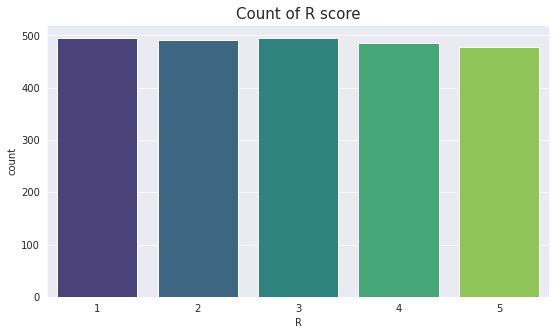

In [75]:
sns.countplot(x='R', data= R_df, palette= "viridis")
plt.xlabel('R')
plt.title('Count of R score', fontsize=15)
plt.show()

It is observed that more than half of the customers have made a transaction recently (in the past 2 months). At the same time there is a significant drop in customers who haven't purchased anything lately. 

This information can be used to identify each customer and:
*   Remind recent customers to revisit the business soon to continue meeting their puchase needs.
*   Make marketing efforts to regain business with inactive customers by offering incentives.

## **4.3 Frequency (F)**

The frequency of a customer’s transactions may be affected by a number of factors like product type, price, need for replenishment or replacement, etc. If the purchase cycle can be predicted, marketing efforts could be directed towards reminding them to visit the business.

**Scoring Methodology:** Count the number of transactions for each customer, split the output into five parts (1-5) with 5 denoting the most frequent customer segment and 1 denoting the least.

In [76]:
# To calculate frequency we will need customer_id and number of transactions
F_df = rfm_df[['customer_id', 'transaction_id']].copy()
F_df = F_df.drop_duplicates().sort_values('customer_id')

F_df.reset_index(drop = True, inplace = True)
F_df.shape

(13488, 2)

In [77]:
F_df.head(2)

,customer_id,transaction_id
0,1,9785
1,1,14931


In [78]:
F_df = F_df.groupby('customer_id',as_index=False).aggregate('count')
F_df = F_df.rename(columns = {'transaction_id': 'frequency'})
F_df.head(2)

,customer_id,frequency
0,1,11
1,2,3


In [79]:
print('Maximum frequency= ',F_df['frequency'].max())
print('Minimum frequency= ',F_df['frequency'].min())

Maximum frequency=  14
Minimum frequency=  1


Segregating customers by assigning a Score from 1 to 5 on the basis on who visits the store more often.

In [80]:
f_labels = range(1, 6)
f_groups = pd.qcut(F_df['frequency'], q=5, labels=f_labels)

F_df = F_df.assign(F = f_groups.values)
F_df.head()

,customer_id,frequency,F
0,1,11,5
1,2,3,1
2,9,6,3
3,12,7,4
4,13,7,4


In [81]:
F_df['F'].value_counts()

1    863
5    457
2    421
3    410
4    292
Name: F, dtype: int64

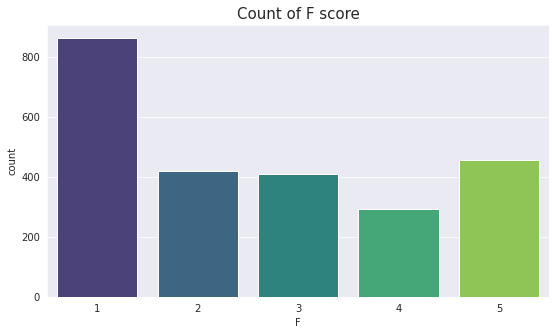

In [82]:
sns.countplot(x='F', data= F_df, palette="viridis")
plt.xlabel('F')
plt.title('Count of F score', fontsize=15)
plt.show()

## **4.4 Monetary Value (M)**

Monetary value provides information on the expenditures of customer during each transaction. A customer who makes a large purchase is more likely to buy again than a customer who spends a lot less.

**Scoring Methodology:** Sum up the trasaction costs for each customer_id and assign a Score from 1-5 where 5 denotes the highest spending customer and 1 denoting the least.

In [83]:
# To calculate monetary value we will need customer_id and the list_price of products sold
M_df = rfm_df[['customer_id', 'list_price']].copy()
M_df = M_df.drop_duplicates().sort_values('customer_id')

M_df.reset_index(drop = True, inplace = True)
M_df.shape

(13061, 2)

In [84]:
M_df.head(2)

,customer_id,list_price
0,1,1720.70
1,1,230.91


In [85]:
M_df = M_df.groupby('customer_id',as_index=False).aggregate('sum')
M_df = M_df.rename(columns = {'list_price': 'monetary_value'})
M_df.head()

,customer_id,monetary_value
0,1,9084.45
1,2,4149.07
2,9,5357.55
3,12,6033.81
4,13,7734.74


In [86]:
print('Maximum monetary value= ', M_df['monetary_value'].max())
print('Minimum monetary value= ', M_df['monetary_value'].min())

Maximum monetary value=  15447.919999999998
Minimum monetary value=  60.34


We further assign score (1-5) to the values obtained in monetary_value column.

In [87]:
m_labels = range(1, 6)
m_groups = pd.qcut(M_df['monetary_value'], q=5, labels=m_labels)

M_df = M_df.assign(M = m_groups.values)
M_df.head()

,customer_id,monetary_value,M
0,1,9084.45,5
1,2,4149.07,2
2,9,5357.55,3
3,12,6033.81,3
4,13,7734.74,4


In [88]:
M_df['M'].value_counts()

5    489
3    489
1    489
4    488
2    488
Name: M, dtype: int64

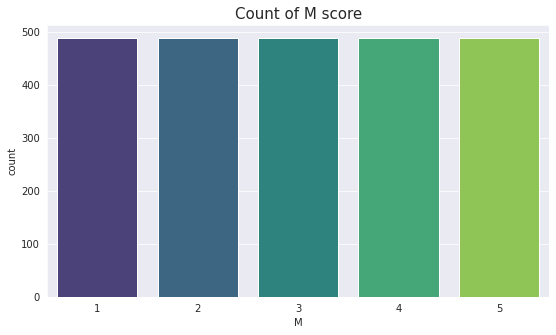

In [89]:
sns.countplot(x='M', data= M_df, palette="viridis")
plt.xlabel('M')
plt.title('Count of M score', fontsize=15)
plt.show()

## **4.5 Final RFM Score**

In this section, various techniques have been discussed for the task of segmentation of customers into different groups with the help of R, F and M Scores.

In [90]:
RFM_df = pd.merge(R_df, F_df[['customer_id','frequency','F']], on=['customer_id'], how='left')
RFM_df = pd.merge(RFM_df, M_df[['customer_id','monetary_value','M']], on=['customer_id'], how='left')

### **4.5.1. Method 1- Concatenation of R, F, M:**

In [91]:
RFM_df['RFM_score_concat'] = RFM_df[['R','F','M']].astype(str).apply(lambda x: ''.join(x), axis = 1)
RFM_df.head()

,customer_id,transaction_date,R_days,R,frequency,F,monetary_value,M,RFM_score_concat
0,1,2017-12-23,7,5,11,5,9084.45,5,555
1,2,2017-08-24,128,1,3,1,4149.07,2,112
2,9,2017-10-13,78,2,6,3,5357.55,3,233
3,12,2017-10-24,67,2,7,4,6033.81,3,243
4,13,2017-12-03,27,4,7,4,7734.74,4,444


In [92]:
RFM_df['RFM_score_concat'].nunique()

109

Using the **concatenation** method, we got **109 different customer segments** with is **not feasible** in practical use. So we will follow **another popular approach** of **summing the R, F, M score** for each customer_id.


### **4.5.2. Method 2- Summing up of R, F, M:**
Summing the scores to a single number and defining RFM levels for each score range.

In [93]:
RFM_df['RFM_score'] = RFM_df[['R', 'F', 'M']].sum(axis = 1)
RFM_df.head()

,customer_id,transaction_date,R_days,R,frequency,F,monetary_value,M,RFM_score_concat,RFM_score
0,1,2017-12-23,7,5,11,5,9084.45,5,555,15.0
1,2,2017-08-24,128,1,3,1,4149.07,2,112,4.0
2,9,2017-10-13,78,2,6,3,5357.55,3,233,8.0
3,12,2017-10-24,67,2,7,4,6033.81,3,243,9.0
4,13,2017-12-03,27,4,7,4,7734.74,4,444,12.0


With this method it can be observed that a customer having R=5, F=2, M=1 holds the same RFM score as another customer having R=1, F=2, M=5 inspite of showing completely different transaction patterns.
Therefore, taking sum of RFM score is also not a reliable metric for customer segmentation.

### **4.5.3. Method 3- K-Means Clustering:**

In [94]:
rfm = RFM_df.copy()

columns = ['R_days', 'frequency', 'monetary_value']
rfm = rfm[columns]
rfm.head()

,R_days,frequency,monetary_value
0,7,11,9084.45
1,128,3,4149.07
2,78,6,5357.55
3,67,7,6033.81
4,27,7,7734.74


In [95]:
scaler = MinMaxScaler()
rfm_std = pd.DataFrame(scaler.fit_transform(rfm), columns=rfm.columns)

In [96]:
inertia = []
ss = []

for k in range(2,11):
  kmeans = KMeans(n_clusters= k+1, random_state= 1231).fit(rfm_std)
  inertia.append(kmeans.inertia_)
  ss.append(metrics.silhouette_score(rfm_std, kmeans.labels_, metric='euclidean'))

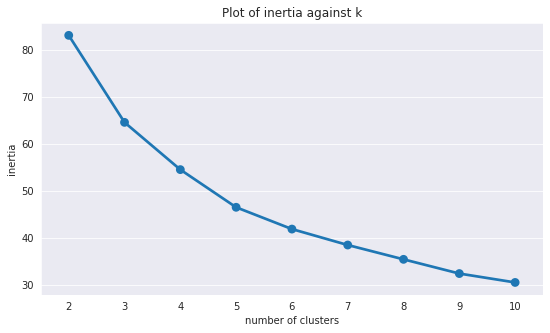

In [97]:
sns.pointplot(x=list(range(2,11)), y=inertia)
plt.title('Plot of inertia against k')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


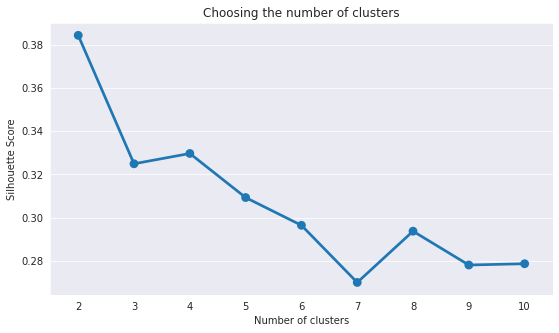

In [98]:
sns.pointplot(list(range(2,11)), ss)
plt.title('Choosing the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Based of the Elbow Graph and Silhoutte Score, the optimal value for number of clusters is **k = 7**

In [99]:
#silhoutte score for k=7
min(ss)

0.2699249724551682

In [100]:
model = KMeans(n_clusters= 7, random_state= 42)
model.fit(rfm_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

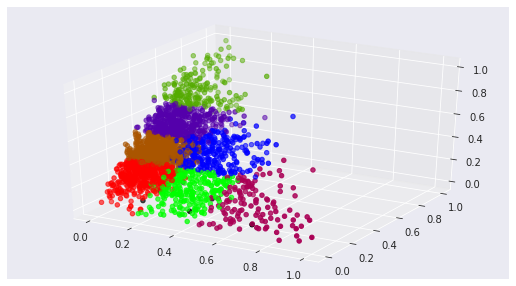

In [101]:
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(rfm_std['R_days'], rfm_std['frequency'], rfm_std['monetary_value'], cmap = 'brg',
           c = model.predict(rfm_std))
ax.scatter(centers[:,0], centers[:,1], c='black')

Dividing the classes into 3 broad segments for studying the output accuracy.

In [102]:
rfm['clusters'] = model.labels_

rfm['Profile'] = model.labels_
rfm['Profile'].replace({0: "Low Segment", 1: "Low Segment", 2: "Low Segment",
                        3: "Mid Segment", 4: "Mid Segment",
                        5: "High Segment", 6: "High Segment"}, inplace = True)

rfm.insert(loc=0, column='customer_id', value= RFM_df['customer_id'])

In [103]:
rfm[rfm['frequency']> 4]

,customer_id,R_days,frequency,monetary_value,clusters,Profile
0,1,7,11,9084.45,5,High Segment
2,9,78,6,5357.55,0,Low Segment
3,12,67,7,6033.81,4,Mid Segment
4,13,27,7,7734.74,1,Low Segment
6,15,35,6,4923.34,4,Mid Segment
...,...,...,...,...,...,...
2429,3484,79,6,8406.81,1,Low Segment
2434,3489,108,6,8300.15,0,Low Segment
2435,3490,166,5,4739.70,0,Low Segment
2438,3493,93,6,10053.82,1,Low Segment


Using KMeans clustering can prove to be one of the best ways of customer segmentation. But we need to keep in mind that while we are employing machine learning techniques there are **chances of misclassification.**

For example, we do not want a frequently visiting customer contributing significantly in terms of monetary value to be placed in the Low Segment as can be observed for customer_id = 13, 3484, 3493, 3495 and many more.

Such errors if occured frequently might question the effectiveness of the model and severely hamper the business.

Let's look at a more personalized approach to segment the customers in the following method.

### **4.5.4. Method 4- Weighted Average:**

At times, the company might find it profitable to focus more on customers who have been frequent visitors(High F score) as well as spend a lot of money on every visit(High M score) but at the same time they might not have been a recent visitor(Low R score). This is just one example which we will consider for analysis, the company requirements may change.

The aim is to demonstrate that, **we can streamline the segmentation process as per the business requirements by using weighted average of the R, F and M scores.**

RFM scoring rubric: (20% of R) + (40% of F) + (40% of M)

In [104]:
rfm_wa = RFM_df.copy()

columns = ['R', 'F', 'M']
rfm_wa = rfm_wa[columns].astype(int)

In [105]:
rfm_wa['RFM_score'] = (.2*rfm_wa['R']) + (.4*rfm_wa['F']) + (.4*rfm_wa['M'])
rfm_wa.head()

,R,F,M,RFM_score
0,5,5,5,5.0
1,1,1,2,1.4
2,2,3,3,2.8
3,2,4,3,3.2
4,4,4,4,4.0


In [106]:
def cluster(df):
  if df['RFM_score'] > 4:
    value = 'Champions'
    group = 5
  elif df['RFM_score'] > 3:
    value = 'Loyal Customers'
    group = 4
  elif df['RFM_score'] > 2:
    value = 'Potential Loyalists'
    group = 3
  elif df['RFM_score'] > 1:
    value = 'At Risk'
    group = 2
  else:
    value = 'Hibernating/Lost'
    group = 1
  return pd.Series([group, value])

In [107]:
rfm_wa[['Group','Customer Profile']] = rfm_wa.apply(cluster, axis = 1)
rfm_wa.head()

,R,F,M,RFM_score,Group,Customer Profile
0,5,5,5,5.0,5,Champions
1,1,1,2,1.4,2,At Risk
2,2,3,3,2.8,3,Potential Loyalists
3,2,4,3,3.2,4,Loyal Customers
4,4,4,4,4.0,4,Loyal Customers


In [108]:
n = rfm_wa.groupby('Customer Profile')[['Group']].sum()

In [109]:
a = rfm_wa.groupby('Customer Profile')[['Group']].sum().index.get_level_values(0).tolist()
print(a)

['At Risk', 'Champions', 'Hibernating/Lost', 'Loyal Customers', 'Potential Loyalists']


In [110]:
d = rfm_wa['Group'].value_counts().tolist()
print(d)

[622, 593, 520, 517, 191]


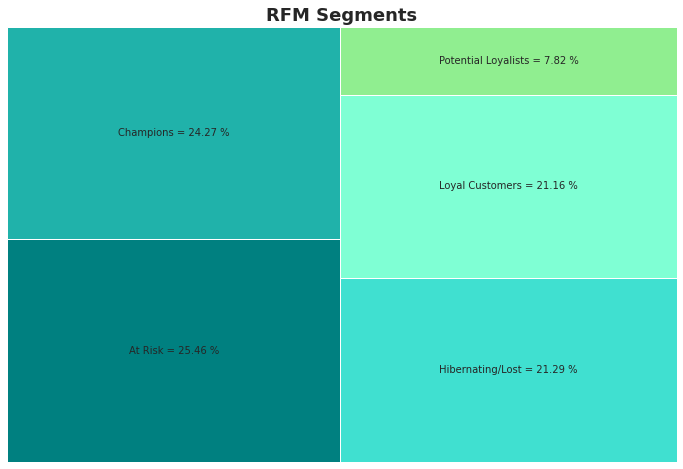

In [111]:
perc = []
colors = ['teal', 'lightseagreen', 'turquoise', 'aquamarine',
             'lightgreen',]

fig = plt.gcf()
fig.set_size_inches(12, 8)

for i in d:
  perc.append(i/sum(d) * 100)

perc = [round(num, 2) for num in perc]

lbl = [f'{el[0]} = {el[1]} %' for el in zip(a, perc)]
squarify.plot(sizes= d, label= lbl, color= colors )

plt.title("RFM Segments", fontsize= 18, fontweight= "bold")
plt.axis('off')
plt.show() 

# **Conclusion:**

A total of 4 methods have been discussed for the purpose of Customer Segmentation. Among them it can be concluded that K-Means Clustering approach (with 7 clusters) is suitable for segmenting the customers based on RFM. Further, a method of calculating weighted average has been discussed which can help to streamline the segmentation process as per business requirements.  

Segments generated can now be interpreted and transposed into business actions as follows:


---



**Champions:**  These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. This can be further improved by analyzing individual preferences for personalized services. 

**Loyal Customers:** These repeat customers are active and loyal. Strategies should be implemented to make them feel valued and rewards can be provided if they spread the word about the brand to their family and friends.

**Potential Loayalists:** These are the Customers with average frequency who spend a good amount. Offer membership or loyalty programs, recommend related products based on their purchase history to make them your Champions or Loyal Customers.

**At Risk:** These are the customers who have not purchased recently.  Send them personalized reactivation campaigns to reconnect, offer renewals and helpful products to encourage another purchase.

**Hibernating/Lost:** These are Customers who have stopped transacting a long time ago. As challenging the task might seem it is important to communicate with them on the basis of their preferences so that they consider getting back in business.


---


Now that we have a clear view of the Segments mentioned above, specific actions can be planned across the Business (Marketing, sales, Operations, Product, etc.) to address any potential issues.


---


Finally, for the data provided for **1000 New Customers** the company should assign a high level of preference to Customers satisfying the following criteria:

*   Customers aged between 41-50 years 
*   State of residence NSW
*   Female Customers, as they are greater in number and spend more compared to males
*   Job Category as Manufacturing, Financial Services or Health

Furthermore, with reference to the comprehensive study of the trends of Existing Customers, their behaviour and subsequent segmentation, the New Customers can be classified similarly once their transaction data is made available.

These New Customers will have a high overall RFM score but they have not been frequent shoppers. The complany should start building relationships with these customers by providing onboarding support and special offers to increase their visits.



